In [1]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

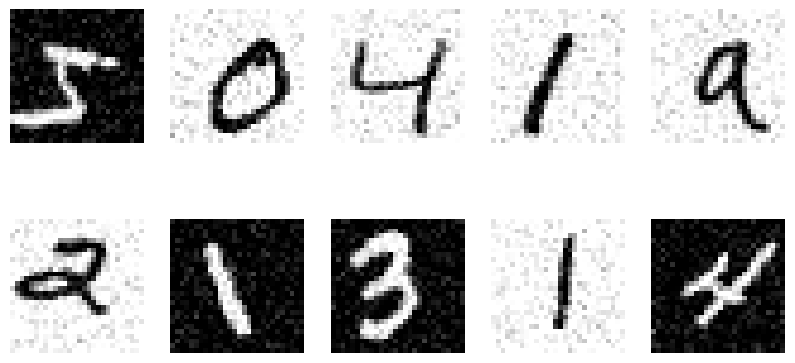

In [9]:
import cv2
from scipy.ndimage import rotate

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the images to [0, 1] and reshape
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Shape (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)    # Shape (10000, 28, 28, 1)

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Function to apply transformations
def transform_image(image):
    # Apply random rotation
    angle = np.random.uniform(-25, 25)  # Rotate between -25 and 25 degrees
    rotated = rotate(image, angle, reshape=False)

    # Apply random translation
    tx, ty = np.random.randint(-3, 3), np.random.randint(-3, 3)  # Shift by max 3 pixels
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    translated = cv2.warpAffine(rotated, translation_matrix, (28, 28))

    # Add Gaussian noise
    noise = np.random.normal(0, 0.1, translated.shape)
    noisy = np.clip(translated + noise, 0, 1)

    # Invert colors randomly
    if np.random.rand() > 0.5:
        inverted = 1 - noisy
    else:
        inverted = noisy

    return np.expand_dims(inverted, axis=-1)

# Apply transformations to a subset of images
x_train_transformed = np.array([transform_image(img.squeeze()) for img in x_train[:60000]])
x_test_transformed = np.array([transform_image(img.squeeze()) for img in x_test[:10000]])

# Visualize some transformed images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train_transformed[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.show()


In [3]:
# Enhanced Vision Transformer Model
class EnhancedVisionTransformer(tf.keras.Model):
    def __init__(self, patch_size=7, embedding_dim=128, num_heads=8, num_classes=10):
        super(EnhancedVisionTransformer, self).__init__()

        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads

        # Patch embedding via Conv2D layer
        self.patch_embedding = tf.keras.layers.Conv2D(embedding_dim, patch_size, strides=patch_size, padding='valid')

        # Positional Encoding Layer
        self.position_embedding = tf.keras.layers.Embedding(1024, embedding_dim)  # For positional encoding

        # Multi-Head Attention Layer
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)

        # Feed Forward Network (FFN)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(embedding_dim, activation='relu'),
            tf.keras.layers.Dense(embedding_dim)
        ])

        # Output layer
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        # Patch embedding
        patches = self.patch_embedding(inputs)

        # Add positional encoding
        pos_encoding = self.position_embedding(tf.range(patches.shape[1]))  # Adding positional encoding
        patches += pos_encoding

        # Multi-head attention
        attention_output = self.multi_head_attention(query=patches, value=patches, key=patches)

        # Feed-forward network
        ffn_output = self.ffn(attention_output)

        # Final classification
        x = self.flatten(ffn_output)
        output = self.dense(x)

        return output

In [4]:
# Simple and clean CNN model
def build_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [5]:
# Function for training and evaluating models
def train_and_evaluate(model, x_train, y_train, x_test, y_test, model_name="Model"):

    test_acc = []
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    # Track training time
    start_time = time.time()
    history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=2)
    end_time = time.time()

    training_duration = (end_time - start_time) / 60

    # Evaluation
    loss, accuracy = model.evaluate(x_test, y_test)
    test_acc.append(accuracy)
    print(f"{model_name} - Training time: {training_duration:.2f} minutes")
    print(f"{model_name} - Test Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    y_pred = np.argmax(model.predict(x_test), axis=-1)
    y_true = np.argmax(y_test, axis=-1)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return test_acc

In [6]:
# Import necessary layers including MultiHeadAttention
from tensorflow.keras.layers import MultiHeadAttention

# Enhanced Vision Transformer Model
class EnhancedVisionTransformer(tf.keras.Model):
    def __init__(self, patch_size=7, embedding_dim=128, num_heads=8, num_classes=10):
        super(EnhancedVisionTransformer, self).__init__()

        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads

        # Patch embedding via Conv2D layer
        self.patch_embedding = tf.keras.layers.Conv2D(embedding_dim, patch_size, strides=patch_size, padding='valid')

        # Positional Encoding Layer
        self.position_embedding = tf.keras.layers.Embedding(1024, embedding_dim)  # For positional encoding

        # Multi-Head Attention Layer
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)

        # Feed Forward Network (FFN)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(embedding_dim, activation='relu'),
            tf.keras.layers.Dense(embedding_dim)
        ])

        # Output layer
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        # Patch embedding
        patches = self.patch_embedding(inputs)

        # Add positional encoding
        pos_encoding = self.position_embedding(tf.range(patches.shape[1]))  # Adding positional encoding
        patches += pos_encoding

        # Multi-head attention
        attention_output = self.multi_head_attention(query=patches, value=patches, key=patches)

        # Feed-forward network
        ffn_output = self.ffn(attention_output)

        # Final classification
        x = self.flatten(ffn_output)
        output = self.dense(x)

        return output


Training CNN Model:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1688/1688 - 136s - 81ms/step - accuracy: 0.8660 - loss: 0.4208 - val_accuracy: 0.9657 - val_loss: 0.1100
Epoch 2/10
1688/1688 - 145s - 86ms/step - accuracy: 0.9544 - loss: 0.1510 - val_accuracy: 0.9750 - val_loss: 0.0914
Epoch 3/10
1688/1688 - 138s - 82ms/step - accuracy: 0.9648 - loss: 0.1149 - val_accuracy: 0.9713 - val_loss: 0.1055
Epoch 4/10
1688/1688 - 146s - 86ms/step - accuracy: 0.9718 - loss: 0.0905 - val_accuracy: 0.9695 - val_loss: 0.0979
Epoch 5/10
1688/1688 - 134s - 79ms/step - accuracy: 0.9766 - loss: 0.0776 - val_accuracy: 0.9753 - val_loss: 0.0895
Epoch 6/10
1688/1688 - 132s - 78ms/step - accuracy: 0.9795 - loss: 0.0653 - val_accuracy: 0.9785 - val_loss: 0.0857
Epoch 7/10
1688/1688 - 127s - 75ms/step - accuracy: 0.9826 - loss: 0.0550 - val_accuracy: 0.9783 - val_loss: 0.0801
Epoch 8/10
1688/1688 - 145s - 86ms/step - accuracy: 0.9844 - loss: 0.0501 - val_accuracy: 0.9805 - val_loss: 0.0809
Epoch 9/10
1688/1688 - 144s - 86ms/step - accuracy: 0.9856 - loss: 0.045

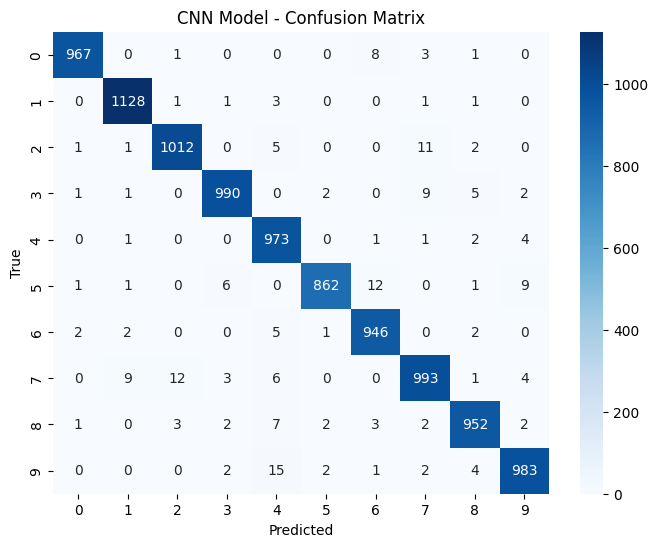

In [10]:
# Train and evaluate CNN Model
print("\nTraining CNN Model:")
cnn_model = build_cnn_model()
cnn_test_acc = train_and_evaluate(cnn_model, x_train_transformed, y_train, x_test_transformed, y_test, model_name="CNN Model")


Training ViT Model:
Epoch 1/10
1688/1688 - 179s - 106ms/step - accuracy: 0.3656 - loss: 1.7896 - val_accuracy: 0.5905 - val_loss: 1.2464
Epoch 2/10
1688/1688 - 154s - 91ms/step - accuracy: 0.6608 - loss: 1.0338 - val_accuracy: 0.7450 - val_loss: 0.7986
Epoch 3/10
1688/1688 - 199s - 118ms/step - accuracy: 0.7557 - loss: 0.7586 - val_accuracy: 0.7897 - val_loss: 0.6677
Epoch 4/10
1688/1688 - 207s - 123ms/step - accuracy: 0.7875 - loss: 0.6574 - val_accuracy: 0.8113 - val_loss: 0.5895
Epoch 5/10
1688/1688 - 154s - 91ms/step - accuracy: 0.8104 - loss: 0.5960 - val_accuracy: 0.8330 - val_loss: 0.5376
Epoch 6/10
1688/1688 - 198s - 117ms/step - accuracy: 0.8212 - loss: 0.5547 - val_accuracy: 0.8565 - val_loss: 0.4642
Epoch 7/10
1688/1688 - 203s - 121ms/step - accuracy: 0.8313 - loss: 0.5288 - val_accuracy: 0.8425 - val_loss: 0.5083
Epoch 8/10
1688/1688 - 206s - 122ms/step - accuracy: 0.8417 - loss: 0.5017 - val_accuracy: 0.8487 - val_loss: 0.4888
Epoch 9/10
1688/1688 - 205s - 121ms/step - ac

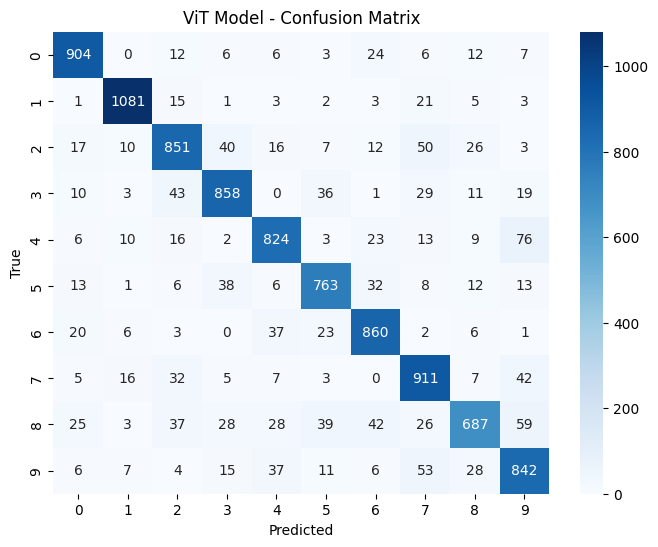

In [12]:
print("\nTraining ViT Model:")
vit_model = EnhancedVisionTransformer()
vit_test_acc = train_and_evaluate(vit_model, x_train_transformed, y_train, x_test_transformed, y_test, model_name="ViT Model")